In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

##### ! Run this script cell by cell - the df gets reread into the notebook in certain cells so running the whole script will not work
##### ! Change the path accordingly

In [47]:
reddit_name = "theworldnews"


CASH_PATH = "C:/Users/peapo/DataSci_Project/DataScienceProject"
MERT_PATH = "/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/"
# CHANGE THIS
OWNER_PATH = CASH_PATH
#

MERGED = f"{OWNER_PATH}/visuals/df_csv/{reddit_name}_df_merged.csv"

Event Ranges with margins before and after

In [49]:

df = pd.read_csv(MERGED)
#df = pd.read_csv(f"Visuals/df_csv/{reddit_name}_df_merged.csv")
#C:\Users\peapo\DataSci_Project\DataScienceProject\Visuals\df_csv\theworldnews_df_merged.csv
df["Date"] = pd.to_datetime(df["Date"])

events = {
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01"),
    "Palestine": ("2023-10-01", "2024-05-01"),
    "Turkey Earthquake" : ("2023-01-01", "2023-04-01"),
    "Arab Spring" : ("2010-12-01", "2012-12-01")
}


for event, (start, end) in events.items():
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    df[event] = df["Date"].apply(lambda x: start <= x <= end)

Getting Sentiment Data

In [50]:
event_sentiment_summary = {}
for event in events:
    event_data = df[df[event]]
    non_event_data = df[~df[event]]
    event_avg = event_data["Polarity"].mean()
    non_event_avg = non_event_data["Polarity"].mean()
    event_sentiment_summary[event] = (event_avg, non_event_avg)

# Display the results
for event, (event_avg, non_event_avg) in event_sentiment_summary.items():
    print(f"{event}: During Event Avg Polarity = {event_avg:.3f}, Outside Event Avg Polarity = {non_event_avg:.3f}")


COVID-19 Pandemic: During Event Avg Polarity = 0.058, Outside Event Avg Polarity = 0.070
Ukraine Conflict: During Event Avg Polarity = 0.076, Outside Event Avg Polarity = 0.067
Biden Election Period: During Event Avg Polarity = 0.049, Outside Event Avg Polarity = 0.074
Trump Election Period: During Event Avg Polarity = 0.061, Outside Event Avg Polarity = 0.072
GTA 5 Release: During Event Avg Polarity = 0.112, Outside Event Avg Polarity = 0.069
Snowden Leak: During Event Avg Polarity = 0.071, Outside Event Avg Polarity = 0.069
Palestine: During Event Avg Polarity = nan, Outside Event Avg Polarity = 0.069
Turkey Earthquake: During Event Avg Polarity = nan, Outside Event Avg Polarity = 0.069
Arab Spring: During Event Avg Polarity = 0.027, Outside Event Avg Polarity = 0.069


#### Visualizing Sentiment Data

In [51]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Span, Label, Legend, LegendItem
import pandas as pd

output_notebook()

Loading BokehJS ...

In [52]:
events = {
    # "Event name" : ("start date", "end date", "color for start", "color for end")
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01", "#1f77b4", "#aec7e8"),  # blue tones
    "Ukraine Conflict": ("2022-01-15", "2023-09-01", "#ff7f0e", "#ffbb78"),  # orange tones
    "Biden Election Period": ("2020-11-01", "2022-01-01", "#2ca02c", "#98df8a"),  # green tones
    "Trump Election Period": ("2016-11-01", "2020-12-31", "#d62728", "#ff9896"),  # red tones
    "GTA 5 Release": ("2013-09-01", "2013-10-30", "#9467bd", "#c5b0d5"),  # purple tones
    "Snowden Leak": ("2013-06-01", "2013-07-01", "#8c564b", "#c49c94"),  # brown tones
    "Palestine": ("2023-10-01", "2024-05-01", "#e377c2", "#f7b6d2"),  # pink tones
    "Turkey Earthquake": ("2023-01-01", "2023-04-01", "#7f7f7f", "#c7c7c7"),  # grey tones
    "Arab Spring": ("2010-12-01", "2012-12-01", "#bcbd22", "#dbdb8d")  # yellow-green tones
}


for event in events:
    start_date, end_date, start_color, end_color = events[event]
    events[event] = (pd.to_datetime(start_date), pd.to_datetime(end_date), start_color, end_color)


In [26]:
# Create a Bokeh plot
p = figure(title="Sentiment Polarity Over Time with Event Markers",
            x_axis_label="Date", y_axis_label="Polarity",
            x_axis_type="datetime", width=1400, height=600,
            tools="pan,wheel_zoom,box_zoom,reset,save")

# Add a line renderer for daily polarity
p.line(df["Date"], df["Polarity"], legend_label="Daily Polarity", line_width=4, color="blue", alpha=0.5)

# Prepare for legend items
legend_items = []

# Process each event
for event, (start_date, end_date, start_color, end_color) in events.items():
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Add start and end lines using thin lines
    p.line([start_date, start_date], [min(df["Polarity"]), max(df["Polarity"])], 
            line_width=4, color=start_color, legend_label=f"{event} Start")
    p.line([end_date, end_date], [min(df["Polarity"]), max(df["Polarity"])], 
            line_width=4, color=end_color, legend_label=f"{event} End")

# Show the plot
show(p)

## ARIMA

In [33]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [34]:
df = pd.read_csv(f"C:/Users/peapo/DataSci_Project/DataScienceProject/Visuals/df_csv/{reddit_name}_df_merged.csv")
#df = pd.read_csv(f"C:/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/visuals/df_csv/{reddit_name}_df_merged.csv")
#C:/Users/peapo/DataSci_Project/DataScienceProject/Visuals
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Assuming "Polarity" is the column with sentiment scores
ts = df["Polarity"]

ARIMA requires the time series to be stationary. 

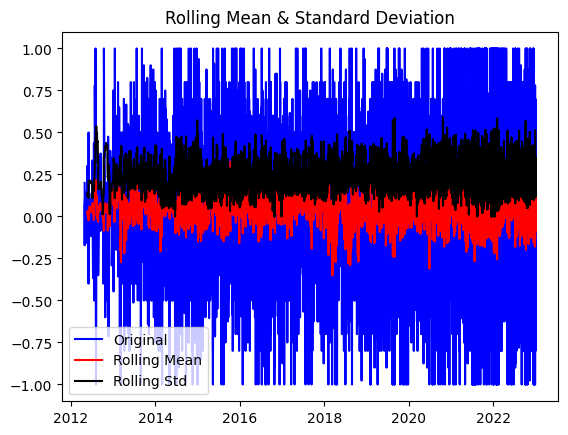

Results of Dickey-Fuller Test:
Test Statistic                -1.637953e+01
p-value                        2.760133e-29
#Lags Used                     4.900000e+01
Number of Observations Used    2.733800e+04
Critical Value (1%)           -3.430589e+00
Critical Value (5%)           -2.861646e+00
Critical Value (10%)          -2.566826e+00
dtype: float64


In [35]:
def test_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag="AIC")
    df_output = pd.Series(df_test[0:4], index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

test_stationarity(ts)

Make the Series Stationary (if needed)

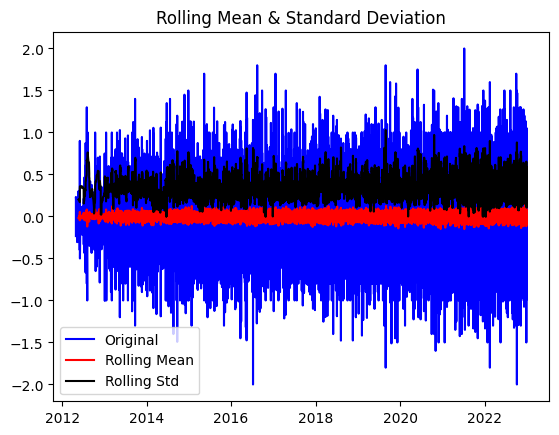

Results of Dickey-Fuller Test:
Test Statistic                   -40.198292
p-value                            0.000000
#Lags Used                        48.000000
Number of Observations Used    27338.000000
Critical Value (1%)               -3.430589
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566826
dtype: float64


In [36]:
ts_diff = ts - ts.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Model Selection: determine the ARIMA parameters

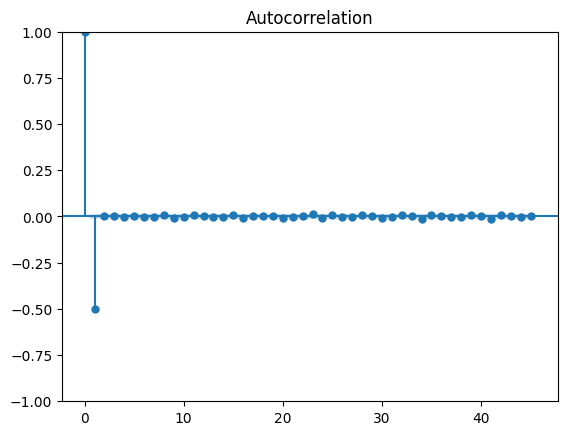

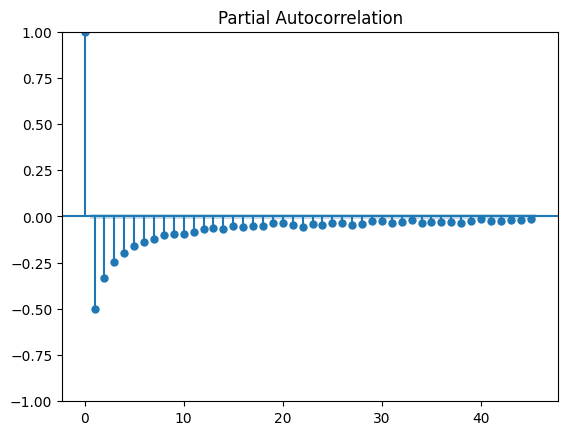

In [37]:
plot_acf(ts_diff)  # To identify the MA(q) order
plot_pacf(ts_diff) # To identify the AR(p) order
plt.show()

                               SARIMAX Results                                
Dep. Variable:               Polarity   No. Observations:                27388
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1617.376
Date:                Sun, 12 May 2024   AIC                           3242.751
Time:                        16:42:01   BIC                           3275.623
Sample:                             0   HQIC                          3253.345
                              - 27388                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0685      0.006     10.556      0.000       0.056       0.081
ar.L1          0.9965      0.001   1203.708      0.000       0.995       0.998
ma.L1         -0.9853      0.002   -608.713      0.0

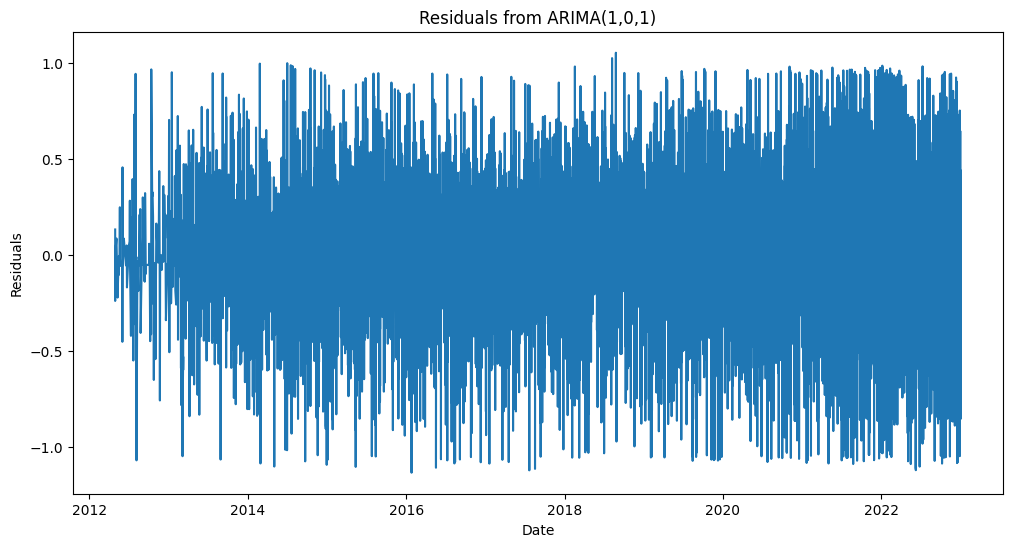

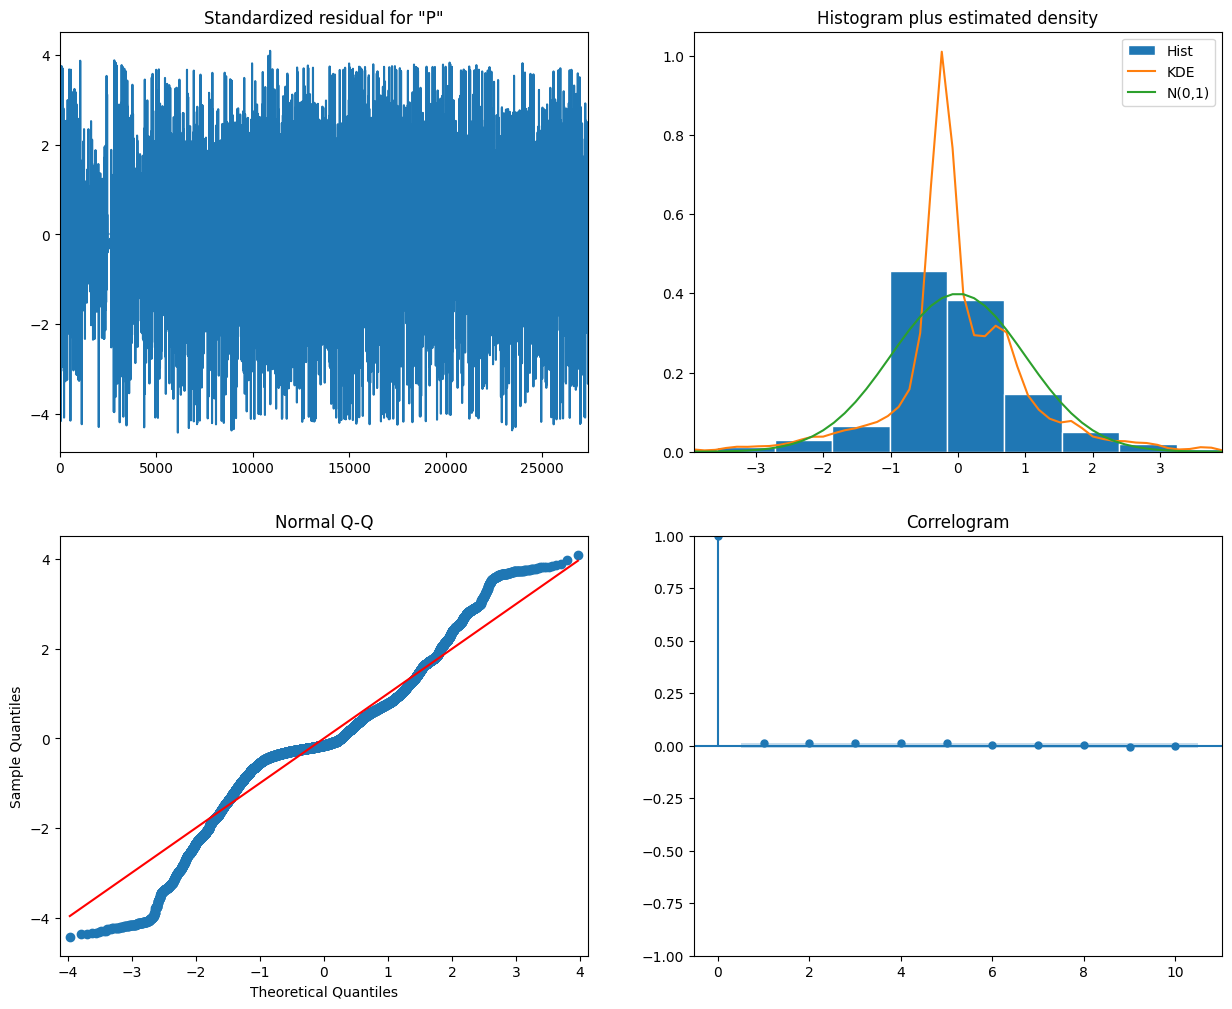

In [38]:
model = ARIMA(ts, order=(1,0,1))  # replace p, d, q with your identified parameters
results = model.fit()
print(results.summary())

residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title("Residuals from ARIMA(1,0,1)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

# Optionally, plot diagnostic plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [39]:
forecast = results.forecast(steps=10)  # forecast next 10 data points
print(forecast)

27388    0.046406
27389    0.046484
27390    0.046562
27391    0.046639
27392    0.046716
27393    0.046793
27394    0.046869
27395    0.046946
27396    0.047022
27397    0.047097
Name: predicted_mean, dtype: float64


## Random Forests

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
df = pd.read_csv(MERGED)

df["Date"] = pd.to_datetime(df["Date"])

events = {
    # "Event name" : ("start date", "end date", "color for start", "color for end")
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01"),
    "Palestine": ("2023-10-01", "2024-05-01"),
    "Turkey Earthquake": ("2023-01-01", "2023-04-01"),
    "Arab Spring": ("2010-12-01", "2012-12-01")
}



for event, (start, end) in events.items():
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    df[event] = df["Date"].apply(lambda x: start <= x <= end)

In [43]:
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df.drop("Date", axis=1, inplace=True)
    
df.dtypes

Text                      object
Polarity                 float64
Subjectivity             float64
COVID-19 Pandemic           bool
Ukraine Conflict            bool
Biden Election Period       bool
Trump Election Period       bool
GTA 5 Release               bool
Snowden Leak                bool
Palestine                   bool
Turkey Earthquake           bool
Arab Spring                 bool
Year                       int32
Month                      int32
Day                        int32
dtype: object

In [44]:
X = df.drop(["Subjectivity", "Text", "COVID-19 Pandemic", "Ukraine Conflict", "Biden Election Period", "Trump Election Period", "GTA 5 Release", "Snowden Leak"], axis=1)
y = df["Polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [45]:
y_pred = regressor.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.3964713105271706e-07
R-squared: 0.9999979364418877


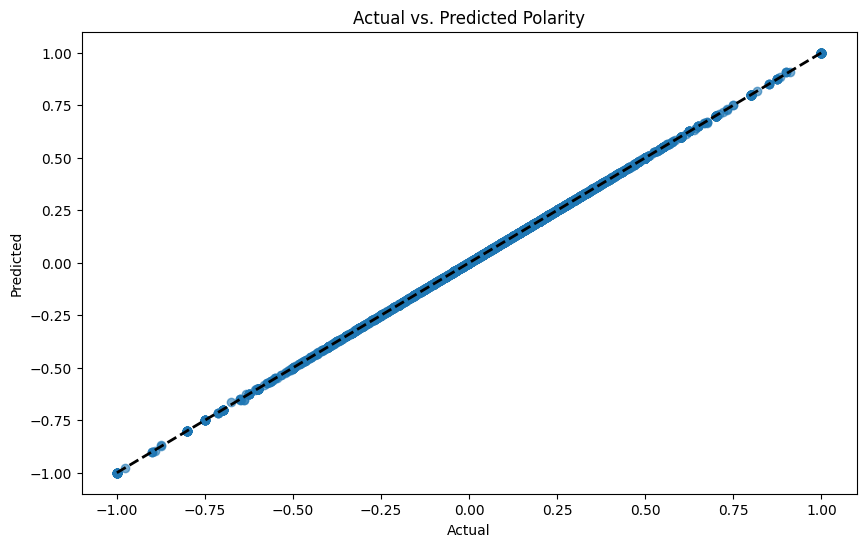

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Line showing perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Polarity')
plt.show()